# Understanding Collaborative Filtering via Matrix Decomposition

written by Dongwon Choi (20244496)

## 0. Introduction

Singular Value Decomposition (SVD)

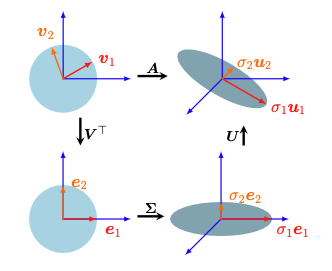


Singular Value Decomposition (SVD) is a mathematical technique used to factorize a given matrix into three other matrices:

Where:

 is the original matrix (e.g., a user-item rating matrix in a recommendation system).

 is an orthogonal matrix representing user-related latent features.

 is a diagonal matrix containing singular values that capture the importance of each feature.

 is an orthogonal matrix representing item-related latent features.

The key idea is that  often contains only a few significant singular values, allowing us to approximate the matrix  using a lower rank representation. This makes SVD a powerful tool for reducing dimensionality and uncovering latent structures in data.

## SVD in Recommender Systems

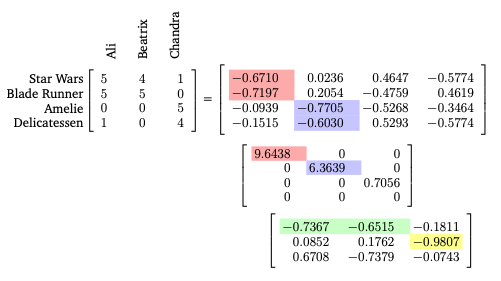

In the context of recommender systems, SVD is widely used to analyze the user-item interaction matrix. For instance, as shown in the figure above, a user-movie rating matrix can be decomposed into two latent matrices, one representing users and the other representing movies. The rank reduction effectively summarizes users' preferences and movies' characteristics in a compressed form.

Collaborative filtering is a core concept tied to this. It leverages interactions (e.g., ratings) between users and items to make predictions. SVD plays a key role by enabling us to identify the latent factors that drive user preferences and item characteristics. For example, during the Netflix Prize Challenge, SVD-based approaches were pivotal in advancing the accuracy of movie recommendations.

A fundamental assumption in matrix factorization methods like SVD is that the preferences of all users can be represented as a linear combination of a small number of latent vectors. This assumption justifies treating the problem as a low-rank matrix completion task rather than merely collaborative filtering.

Low-rank matrix completion aims to fill in the missing entries of a sparse matrix by leveraging its low-rank structure. This formulation has been instrumental in the design of modern recommendation algorithms and has spurred innovations beyond collaborative filtering.

## Scope of This Notebook

In this notebook, we aim to explore various methods to solve the low-rank matrix completion problem, ranging from traditional SVD to advanced neural network-based approaches. Specifically, we will:

1. Implement SVD: Understand how to decompose a matrix and use it for recommendations.

2. Apply ALS (Alternating Least Squares): Utilize an optimization-driven approach to factorize the matrix.

3. Leverage Neural Collaborative Filtering (NCF): Explore deep learning techniques to model user-item interactions.

This comprehensive journey will help us understand the theoretical foundations and practical implementations of recommender systems. Let’s dive in!

In [1]:
!pip install fastai matplotlib seaborn numpy scikit-learn

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Missing value ratio in the User-Movie Rating Matrix: 93.70%


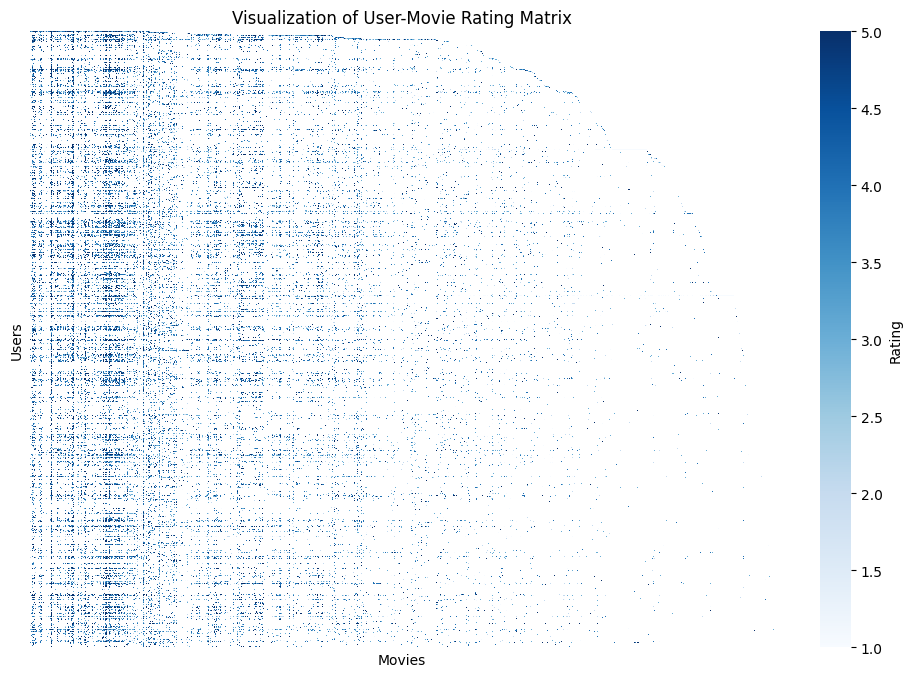

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

user_item_matrix = ratings.pivot(index='user', columns='movie', values='rating')

# calculate missing value ratio
missing_ratio = user_item_matrix.isnull().mean().mean() * 100
print(f"Missing value ratio in the User-Movie Rating Matrix: {missing_ratio:.2f}%")

# visualize sparsity
plt.figure(figsize=(12, 8))
sns.heatmap(user_item_matrix, cmap='Blues', cbar=True, square=False, 
            xticklabels=False, yticklabels=False, 
            cbar_kws={'label': 'Rating'})
plt.title("Visualization of User-Movie Rating Matrix")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

# 2. Implement SVD-based Collaborative Filtering

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

filled_matrix = user_item_matrix.fillna(0).values

def compute_svd(matrix, k):
    U, sigma, Vt = np.linalg.svd(matrix, full_matrices=False)
    sigma = np.diag(sigma[:k])
    U = U[:, :k]
    Vt = Vt[:k, :]
    return U, sigma, Vt

def train_test_split(ratings, test_size=0.2):
    test_indices = []
    for user in ratings['user'].unique():
        user_data = ratings[ratings['user'] == user]
        test_indices.extend(user_data.sample(frac=test_size, random_state=42).index)
        test_set = ratings.loc[test_indices]
        train_set = ratings.drop(test_indices)
    return train_set, test_set

train_ratings, test_ratings = train_test_split(ratings, test_size=0.2)


k=3
train_matrix = train_ratings.pivot(index='user', columns='movie', values='rating').fillna(0).values
U_train, sigma_train, Vt_train = compute_svd(train_matrix, k)
reconstructed_train = np.dot(np.dot(U_train, sigma_train), Vt_train)

predictions = []
actuals = []

for _, row in test_ratings.iterrows():
    user, movie, actual_rating = int(row['user']) - 1, int(row['movie']) - 1, row['rating']
    if user < reconstructed_train.shape[0] and movie < reconstructed_train.shape[1]:
        predicted_rating = reconstructed_train[user, movie]
        predictions.append(predicted_rating)
        actuals.append(actual_rating)

rmse = sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 2.7886
MAE: 2.5280


# 3. Implement ALS-based Collaborative Filtering

In [ ]:
import numpy as np
import pandas as pd

# ALS Implementation
class ALS:
    def __init__(self, num_factors=10, reg=0.1, num_iters=10):
        self.num_factors = num_factors
        self.reg = reg
        self.num_iters = num_iters

    def fit(self, ratings):
        self.ratings = ratings
        self.num_users, self.num_items = ratings.shape

        # Initialize user and item latent factor matrices
        self.user_factors = np.random.rand(self.num_users, self.num_factors)
        self.item_factors = np.random.rand(self.num_items, self.num_factors)

        for _ in range(self.num_iters):
            self.user_factors = self._als_step(self.user_factors, self.item_factors, self.ratings)
            self.item_factors = self._als_step(self.item_factors, self.user_factors, self.ratings.T)

    def _als_step(self, fixed_factors, changing_factors, ratings):
        lambda_eye = self.reg * np.eye(self.num_factors)
        updated_factors = np.zeros_like(fixed_factors)

        for i in range(fixed_factors.shape[0]):
            non_zero_indices = ratings[i, :] > 0
            if np.sum(non_zero_indices) == 0:
                continue

            V = changing_factors[non_zero_indices, :]
            r = ratings[i, non_zero_indices]

            updated_factors[i, :] = np.linalg.solve(V.T @ V + lambda_eye, V.T @ r)

        return updated_factors

    def predict(self):
        return self.user_factors @ self.item_factors.T

# Fill missing values with 0 for ALS
user_item_matrix = ratings.pivot(index='user', columns='movie', values='rating')
data_filled = user_item_matrix.fillna(0).values

# Train ALS model
als = ALS(num_factors=50, reg=0.1, num_iters=15)
als.fit(data_filled)

# Predict ratings
predicted_ratings = als.predict()
predicted_ratings_df = pd.DataFrame(predicted_ratings, 
                                    index=user_item_matrix.index, 
                                    columns=user_item_matrix.columns)


# 4. Implement SGD-based Collaborative Filtering

# 5. Implement Neural Collaborative Filtering (NCF)

# 6. Conclusion

## Reference